## Tutorial: DAOSYS Simulator 
### June 2022
* Step-by-step breakdown of a DAOSYS tokenomic simulation
* Alpha version is subject to modification and updates

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/tutorials","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.event import Mint

from python.dev.simulation.batch import WithdrawBatch
from python.dev.simulation.batch import DepositBatch
from python.dev.simulation.batch import LPDepositBatch
from python.dev.simulation.batch import SwapBatch
from python.dev.simulation.batch.set import BatchSet

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

### DAOSYS Simulation: basic workflow

1. Determine agents (ie, user, tokens)
2. Setup liquidity pool (LP)
3. Senerate event sequence and pass into queue
4. Pass queue and LPs to orchestrator
5. Run simulation
6. Analyse output from tokens and LPs


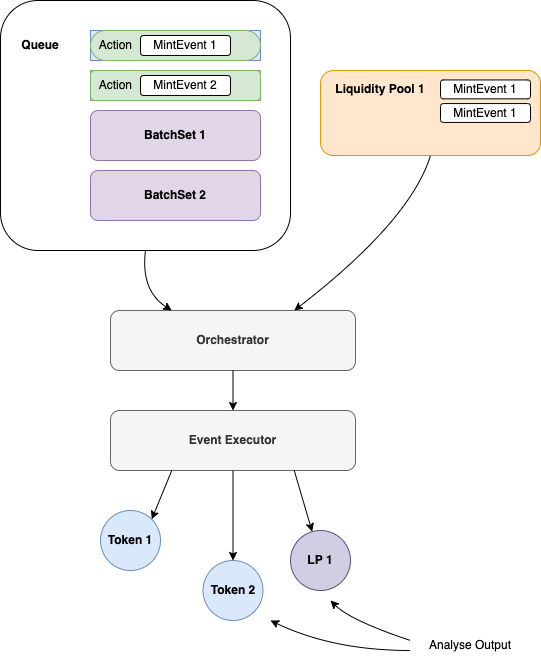

In [2]:
Image("images/jupyter/tutorials/orchestrator.png", width = 300, height = 300)

### Initialize Agents
* **User**: user
* **Tokens**: T1_agent & TCT1_agent 
* **LP Tokens**: LP1_agent
* **Liquidity Pools**: LP1

In [3]:
apy = 0.123456
user = UserAgent('sim_user')
T1_agent = TokenAgent('T1')
TCT1_agent = TokenAgent('TCT')

LP1 = LiquidityPool('T1/TCT', user, T1_agent, TCT1_agent)
LP1_agent = LPTokenAgent('LP1', LP1)

### Delta Models
* **Token deltas**: set of token deltas generated from a randomly sampled gamma distribution
* **Time deltas**: set of time deltas generated from a randomly sampled negative binomial distribution 

#### Number of action events: 100

In [4]:
n_events = 100
token_deltas = TokenDeltaModel(1,100).apply(n_events) 
time_deltas = TimeDeltaModel().apply(n_events)

### Setup Events
Events are single actions that are programmed into a DAOSYS simulation and are classified by the following

* **Event** (4 types):
    * *Mint*: initialize a token and assign an address
    * *Deposit*: deposit liquidity into a token
    * *Withdraw*: withdraw liquidity from a token
    * *Swap*: swap liquidity between two tokens
* **Action**: wrapped events assigned to user and token agents
* **Batch**: is a batch of action events belonging to a particular action
* **Batchset**: is a collection of batches which result in a list of action events that get passed into the queue; this allows a grouping of actions to be sandboxed against other groupings of actions

*For this simulation, we include*:

* **3 Mint events**
    * 1 non-rebase token ```Mint(10000, apy, False)```
    * 1 rebase token ```Mint(10000, apy, True)``` 
    * 1 LP rebase token ``` Mint(0, apy, True)``` 
* **1 Batchset**
    * 2 Deposit batches ```DepositBatch(T1_agent, user, T1_mint)```
    * 1 Swap batches ```SwapBatch(withdraw_sub_batch, deposit_sub_batch)```
    * 1 LP deposit batches ```LPDepositBatch(LP1_agent, user, LP1_mint)```
* **1 Liquidity Pool**    

In [5]:
T1_mint = Mint(10000, apy, False)
TCT1_mint = Mint(10000, apy, True)
LP1_mint = Mint(0, apy, True)

batch1 = DepositBatch(T1_agent, user, T1_mint)
batch2 = DepositBatch(TCT1_agent, user, TCT1_mint)
withdraw_sub_batch = WithdrawBatch(T1_agent, user, T1_mint)
deposit_sub_batch = DepositBatch(TCT1_agent, user, TCT1_mint)
batch3 = SwapBatch(withdraw_sub_batch, deposit_sub_batch)
batch4 = LPDepositBatch(LP1_agent, user, LP1_mint)

batch1.set_token_deltas(token_deltas)
batch2.set_token_deltas(token_deltas)
batch3.set_token_deltas(token_deltas)

batch1.set_time_deltas(time_deltas)
batch2.set_time_deltas(time_deltas)
batch3.set_no_time_delay(True) 
batch4.set_time_deltas(time_deltas)

* **Event** (4 types):
    * Mint: initialize a token
    * Deposit: deposit liquidity into a token
    * Withdraw: withdraw liquidity from a token
    * Swap: swap liquidity between two tokens
* **Action**: wrapped events assigned to user and token agents
* **Batch**: is a batch of action events belonging to a particular action
* **Batchset**: is a collection of batches which result in a list of action events that get passed into the queue; this allows a grouping of actions to be sandboxed against other groupings of actions, and possibly allow for concurent execution of events

#### Batchset setup

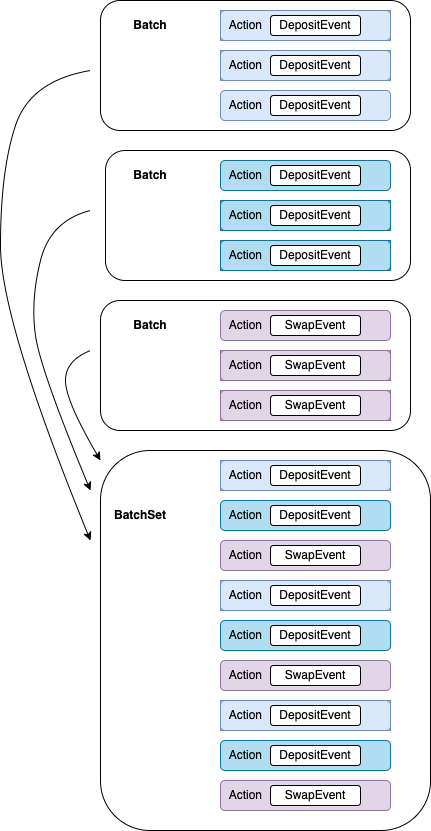

In [6]:
Image("images/jupyter/tutorials/batchset.png", width = 300, height = 300)

### Generate events 

In [7]:
batch_set1 = BatchSet('batch_set_1', True)
batch_set1.add_batch(batch1, 'deposit_t1', )
batch_set1.add_batch(batch2, 'deposit_tct1')
batch_set1.add_batch(batch3, 'swap_t1_tct1')
batch_set1.add_batch(batch4, 'deposit_t1_tct1_lp')

sim_batch1 = batch_set1.generate_events(apy, n_events)

======== Batch Set Tasks ===========
# name: batch_set_1
# num_repeats: 100 

[task 1] deposit_t1
[task 2] deposit_tct1
[task 3] swap_t1_tct1
[task 4] deposit_t1_tct1_lp



### Event Queue
* Last in first out (LIFO)
* Queue consists of:
    * 3 mint actions
    * 1 batch set of action events (see above)

In [8]:
q = EventQueue()
q.add_event(MintAction(T1_mint, T1_agent, user))
q.add_event(MintAction(TCT1_mint, TCT1_agent, user))
q.add_event(MintAction(LP1_mint, LP1_agent, user))
q.add_event_batch(sim_batch1)

### Execute
* Pass event queue of action events through the event executor
* Add liquidity pool(s)
* Run simulation

In [9]:
orchestrator = SimulationOrchestrator(verbose = False)
orchestrator.add_liquidity_pool(LP1)

executor = EventExecutor(q, orchestrator)
executor.run()

### Analyze output
* 2 tokens
* 1 LP token
* 1 Liquidity pool

In [10]:
# tokens
T1 = T1_agent.get_token()
TCT1 = TCT1_agent.get_token()
LP1 = LP1_agent.get_token()

# liquidity pool
T1_TCT1_LP = orchestrator.get_liquidity_pool('T1/TCT')

#### Investigate token balances

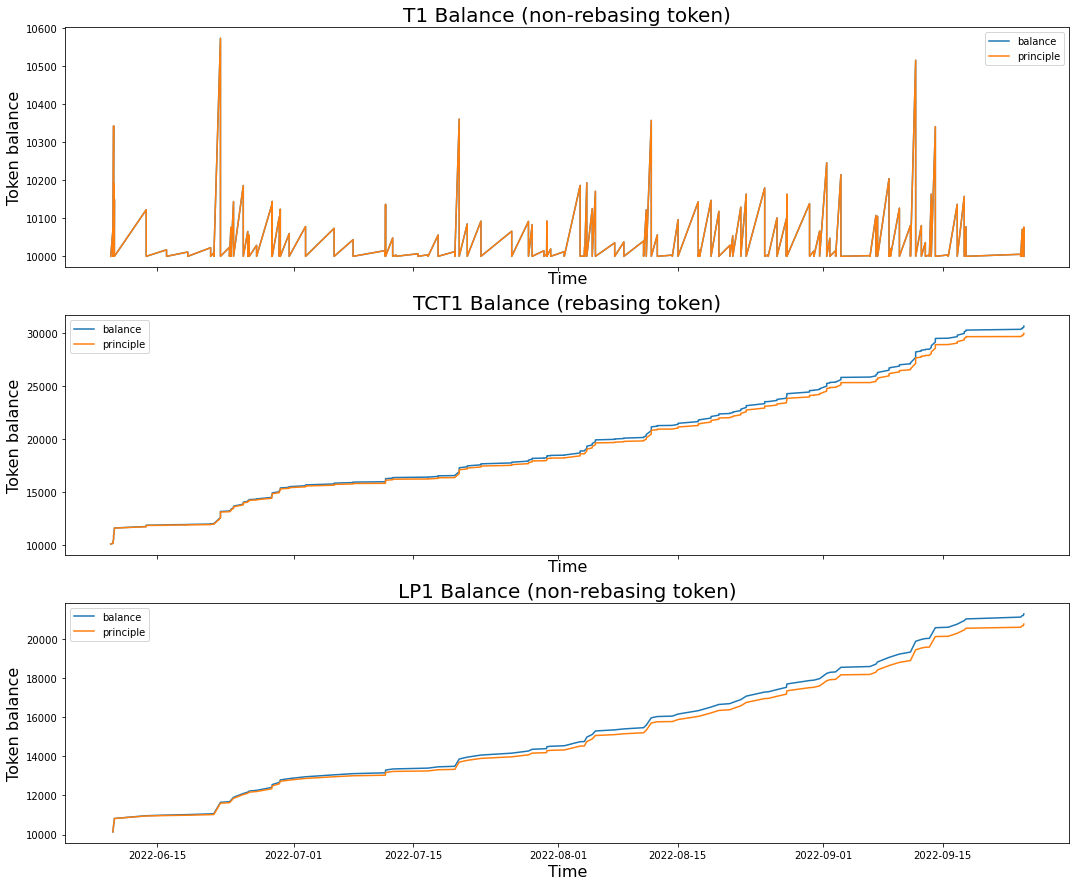

In [11]:
# Get token addresses

t1_addr = T1_agent.get_address(T1_mint.get_id())
tct_addr = TCT1_agent.get_address(TCT1_mint.get_id())
lp1_addr = LP1_agent.get_address(LP1_mint.get_id())

# Analyze Token balances

T1_states = T1.get_state_series(t1_addr)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TCT1_ax, LP1_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (non-rebasing token)", fontsize=20)
T1_ax.set_ylabel("Token balance", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TCT1_states = TCT1.get_state_series(tct_addr)
principle = TCT1_states.get_principle() 
balance = TCT1_states.get_balance() 
tSamp = TCT1_states.get_tstamp() 

TCT1_ax.plot(tSamp[1:], balance[1:], label='balance') 
TCT1_ax.plot(tSamp[1:], principle[1:], label='principle') 
TCT1_ax.set_title("TCT1 Balance (rebasing token)", fontsize=20)
TCT1_ax.set_ylabel("Token balance", fontsize=16)
TCT1_ax.set_xlabel('Time', fontsize=16)
TCT1_ax.legend()

LP1_states = LP1.get_state_series(lp1_addr)
principle = LP1_states.get_principle() 
balance = LP1_states.get_balance() 
tSamp = LP1_states.get_tstamp() 

LP1_ax.plot(tSamp[1:], balance[1:], label='balance') 
LP1_ax.plot(tSamp[1:], principle[1:], label='principle') 
LP1_ax.set_title("LP1 Balance (non-rebasing token)", fontsize=20)
LP1_ax.set_ylabel("Token balance", fontsize=16)
LP1_ax.set_xlabel('Time', fontsize=16)
LP1_ax.legend()


#### Liquidity pool balance

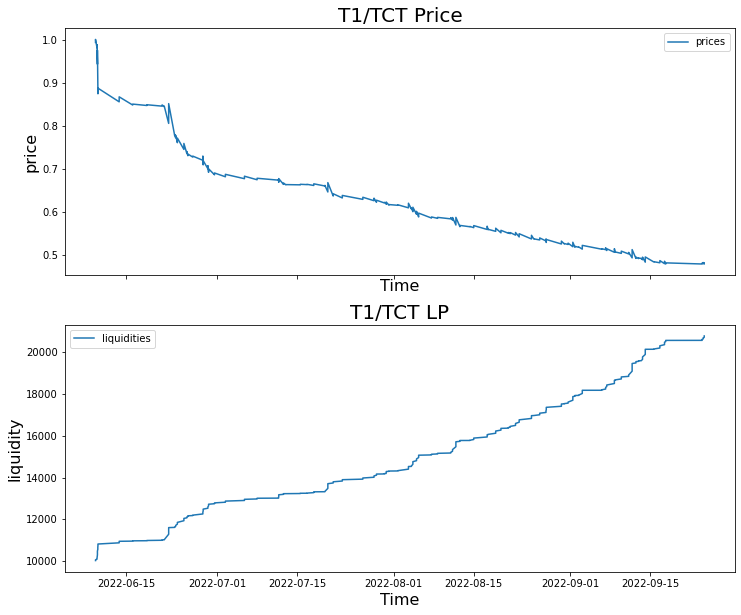

In [12]:
tSamp = T1_TCT1_LP.get_lp_events().get_dates()
prices = T1_TCT1_LP.get_lp_events().get_prices()
liquidities = T1_TCT1_LP.get_lp_events().get_liquidity_values()

fig, (L_ax, P_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

L_ax.plot(tSamp[1:], prices[1:], label='prices') 
L_ax.set_title("T1/TCT Price", fontsize=20)
L_ax.set_ylabel("price", fontsize=16)
L_ax.set_xlabel('Time', fontsize=16)
L_ax.legend()

P_ax.plot(tSamp[1:], liquidities[1:], label='liquidities') 
P_ax.set_title("T1/TCT LP", fontsize=20)
P_ax.set_ylabel("liquidity", fontsize=16)
P_ax.set_xlabel('Time', fontsize=16)
P_ax.legend()